# SAM8905 Reverb FX - ALG 1 Analysis (Diffusion)

This notebook analyzes ALG 1 of the Keyfox10 reverb effect.

**ALG 1 Purpose:** Diffusion/scatter processing - spreads early reflections for a more natural reverb sound.

**Key characteristics:**
- Located at A-RAM 0x40-0x7F (22kHz ALG 1)
- Used by Slot 5 (D-RAM ALG=2)
- Heavy DAC output: 13 WACC instructions
- No WXY+WSP combo (uses MIX values from previous slot)
- Reads from D-RAM and SRAM for extensive multiply-accumulate operations

In [67]:
import sys
sys.path.insert(0, '..')

import numpy as np
import matplotlib.pyplot as plt
from importlib import reload

import sam8905_interpreter
reload(sam8905_interpreter)

from sam8905_interpreter import (
    SAM8905Interpreter,
    plot_waveform,
    export_wav,
    print_state,
    print_dram_changes
)
from sam8905_aram_decoder import decode_algorithm

%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 4)

## ALG 1 from Keyfox10 FX Chip

A-RAM addresses 0x40-0x7F (64 instructions for 22kHz ALG 1)

In [68]:
# A-RAM 0x40-0x7F: 22kHz ALG 1 (D-RAM ALG=2, Used by Slot 5 - Diffusion)
# From WIP_fx_reverb_analysis.md
aram_alg1 = [
    0x30EF,  # PC00: RM 6, <WPHI>                      - PHI = D[6]
    0x48FD,  # PC01: RM 9, <WWF>                       - WWF = D[9] (waveform config)
    0x6ADF,  # PC02: RADD 13, <WM>                     - D[13] = A+B
    0x703F,  # PC03: RM 14, <WA, WB>                   - A=B=D[14]
    0x0000,  # PC04: RM 0, <WA,WB,WM,WPHI,WXY,clrB,WWF,WACC>  - WACC #1
    0x6BDF,  # PC05: RADD 13, <WM> [WSP]               - D[13] = A+B, WSP active
    0x38EF,  # PC06: RM 7, <WPHI>                      - PHI = D[7]
    0x50FC,  # PC07: RM 10, <WWF,WACC>                 - WWF=D[10], WACC #2
    0x687F,  # PC08: RM 13, <WA>                       - A = D[13]
    0x7CBE,  # PC09: RP 15, <WB,WACC>                  - B = product, WACC #3
    0x18F7,  # PC10: RM 3, <WXY>                       - WXY - waveform read
    0x7A7F,  # PC11: RADD 15, <WA>                     - A = A+B
    0x40EF,  # PC12: RM 8, <WPHI>                      - PHI = D[8]
    0x58FC,  # PC13: RM 11, <WWF,WACC>                 - WWF=D[11], WACC #4
    0x7CBE,  # PC14: RP 15, <WB,WACC>                  - B = product, WACC #5
    0x6ADF,  # PC15: RADD 13, <WM>                     - D[13] = A+B
    0x18F7,  # PC16: RM 3, <WXY>                       - WXY - waveform read
    0x00BF,  # PC17: RM 0, <WB>                        - B = D[0]
    0x307F,  # PC18: RM 6, <WA>                        - A = D[6]
    0x32CE,  # PC19: RADD 6, <WM,WPHI,WACC>            - D[6]=A+B, PHI=bus, WACC #6
    0x48FC,  # PC20: RM 9, <WWF,WACC>                  - WWF=D[9], WACC #7
    0x387F,  # PC21: RM 7, <WA>                        - A = D[7]
    0x3ADF,  # PC22: RADD 7, <WM>                      - D[7] = A+B
    0x407F,  # PC23: RM 8, <WA>                        - A = D[8]
    0x42DF,  # PC24: RADD 8, <WM>                      - D[8] = A+B
    0x7CBF,  # PC25: RP 15, <WB>                       - B = product
    0x20F7,  # PC26: RM 4, <WXY>                       - WXY - waveform read
    0x687F,  # PC27: RM 13, <WA>                       - A = D[13]
    0x38EF,  # PC28: RM 7, <WPHI>                      - PHI = D[7]
    0x50FD,  # PC29: RM 10, <WWF>                      - WWF = D[10]
    0x7A7E,  # PC30: RADD 15, <WA,WACC>                - A=A+B, WACC #8
    0x7CBE,  # PC31: RP 15, <WB,WACC>                  - B = product, WACC #9
    0x28F7,  # PC32: RM 5, <WXY>                       - WXY - waveform read
    0x7A7F,  # PC33: RADD 15, <WA>                     - A = A+B
    0x40EF,  # PC34: RM 8, <WPHI>                      - PHI = D[8]
    0x58FD,  # PC35: RM 11, <WWF>                      - WWF = D[11]
    0x7CBE,  # PC36: RP 15, <WB,WACC>                  - B = product, WACC #10
    0x6ADE,  # PC37: RADD 13, <WM,WACC>                - D[13]=A+B, WACC #11
    0x28F7,  # PC38: RM 5, <WXY>                       - WXY - waveform read
    0x08BF,  # PC39: RM 1, <WB>                        - B = D[1]
    0x307F,  # PC40: RM 6, <WA>                        - A = D[6]
    0x32DF,  # PC41: RADD 6, <WM>                      - D[6] = A+B
    0x493F,  # PC42: RM 9, <WA,WB> [WSP]               - A=B=D[9], WSP active
    0x4ADF,  # PC43: RADD 9, <WM>                      - D[9] = A+B
    0x60BF,  # PC44: RM 12, <WB>                       - B = D[12]
    0x4BDF,  # PC45: RADD 9, <WM> [WSP]                - D[9]=A+B, WSP active
    0x08BF,  # PC46: RM 1, <WB>                        - B = D[1]
    0x387F,  # PC47: RM 7, <WA>                        - A = D[7]
    0x3ADF,  # PC48: RADD 7, <WM>                      - D[7] = A+B
    0x513F,  # PC49: RM 10, <WA,WB> [WSP]              - A=B=D[10], WSP active
    0x52DF,  # PC50: RADD 10, <WM>                     - D[10] = A+B
    0x60BF,  # PC51: RM 12, <WB>                       - B = D[12]
    0x53DF,  # PC52: RADD 10, <WM> [WSP]               - D[10]=A+B, WSP active
    0x08BF,  # PC53: RM 1, <WB>                        - B = D[1]
    0x407F,  # PC54: RM 8, <WA>                        - A = D[8]
    0x42DF,  # PC55: RADD 8, <WM>                      - D[8] = A+B
    0x593F,  # PC56: RM 11, <WA,WB> [WSP]              - A=B=D[11], WSP active
    0x5ADF,  # PC57: RADD 11, <WM>                     - D[11] = A+B
    0x60BF,  # PC58: RM 12, <WB>                       - B = D[12]
    0x5BDF,  # PC59: RADD 11, <WM> [WSP]               - D[11]=A+B, WSP active
    0x7CBE,  # PC60: RP 15, <WB,WACC>                  - B = product, WACC #12
    0x687E,  # PC61: RM 13, <WA,WACC>                  - A = D[13], WACC #13
]

# Pad to 64 instructions (PC62-63 are reserved NOPs)
aram_alg1 += [0x7FFF] * (64 - len(aram_alg1))

print(f"ALG 1: {len(aram_alg1)} instructions")
print()
print(decode_algorithm(aram_alg1, 1))

ALG 1: 64 instructions

=== Algorithm 1 ===

PC00: 30EF  RM 6, <WPHI>
PC01: 48FD  RM 9, <WWF>
PC02: 6ADF  RADD 13, <WM>
PC03: 703F  RM 14, <WA, WB>
PC04: 0000  RM 0, <WA, WB, WM, WPHI, WXY, clearB, WWF, WACC>
PC05: 6BDF  RADD 13, <WM, WSP> ***
PC06: 38EF  RM 7, <WPHI>
PC07: 50FC  RM 10, <WWF, WACC>
PC08: 687F  RM 13, <WA>
PC09: 7CBE  RP, <WB, WACC>
PC10: 18F7  RM 3, <WXY>
PC11: 7A7F  RADD, <WA>
PC12: 40EF  RM 8, <WPHI>
PC13: 58FC  RM 11, <WWF, WACC>
PC14: 7CBE  RP, <WB, WACC>
PC15: 6ADF  RADD 13, <WM>
PC16: 18F7  RM 3, <WXY>
PC17: 00BF  RM 0, <WB>
PC18: 307F  RM 6, <WA>
PC19: 32CE  RADD 6, <WM, WPHI, WACC>
PC20: 48FC  RM 9, <WWF, WACC>
PC21: 387F  RM 7, <WA>
PC22: 3ADF  RADD 7, <WM>
PC23: 407F  RM 8, <WA>
PC24: 42DF  RADD 8, <WM>
PC25: 7CBF  RP, <WB>
PC26: 20F7  RM 4, <WXY>
PC27: 687F  RM 13, <WA>
PC28: 38EF  RM 7, <WPHI>
PC29: 50FD  RM 10, <WWF>
PC30: 7A7E  RADD, <WA, WACC>
PC31: 7CBE  RP, <WB, WACC>
PC32: 28F7  RM 5, <WXY>
PC33: 7A7F  RADD, <WA>
PC34: 40EF  RM 8, <WPHI>
PC35: 58FD  R

## D-RAM Configuration (Slot 5 - Diffusion)

In [69]:
# D-RAM for Slot 5 (ALG 1 / Diffusion)
# From WIP_fx_reverb_analysis.md
dram_slot5 = [
    0x00080,  # word 0: PHI offset / constant
    0x00180,  # word 1: Modulation offset
    0x1003F,  # word 2: WWF config (external waveform)
    0x10000,  # word 3: Amplitude (Y=0x200 = +0.25 Q0.11)
    0x00100,  # word 4: Amplitude (Y=0x002 = +0.001 Q0.11)
    0x00100,  # word 5: Amplitude (Y=0x002 = +0.001 Q0.11)
    0x3FF00,  # word 6: Large delay address
    0x6DF00,  # word 7: Delay address (phase modulation)
    0x5A100,  # word 8: Delay address (phase modulation)
    0x40402,  # word 9: WWF/SRAM bank config
    0x40402,  # word 10: WWF/SRAM bank config
    0x40402,  # word 11: WWF/SRAM bank config
    0x40402,  # word 12: Modulation depth
    0x00000,  # word 13: Working accumulator
    0x40000,  # word 14: Feedback state
    0x3C280,  # word 15: 0011 1100 0010 1000 0000 → IDLE=0, ALG=2 (22kHz ALG 1)
]

print("D-RAM Slot 5 configuration:")
for i, val in enumerate(dram_slot5):
    signed_val = val if val < 0x40000 else val - 0x80000
    # Also show Y value (bits 18:7) for amplitude words
    y_val = (val >> 7) & 0xFFF
    y_signed = y_val if y_val < 0x800 else y_val - 0x1000
    q011 = y_signed / 2048.0
    print(f"  D[{i:2d}] = 0x{val:05X} (signed: {signed_val:+8d}, Y={y_signed:+5d} = {q011:+.4f} Q0.11)")

D-RAM Slot 5 configuration:
  D[ 0] = 0x00080 (signed:     +128, Y=   +1 = +0.0005 Q0.11)
  D[ 1] = 0x00180 (signed:     +384, Y=   +3 = +0.0015 Q0.11)
  D[ 2] = 0x1003F (signed:   +65599, Y= +512 = +0.2500 Q0.11)
  D[ 3] = 0x10000 (signed:   +65536, Y= +512 = +0.2500 Q0.11)
  D[ 4] = 0x00100 (signed:     +256, Y=   +2 = +0.0010 Q0.11)
  D[ 5] = 0x00100 (signed:     +256, Y=   +2 = +0.0010 Q0.11)
  D[ 6] = 0x3FF00 (signed:  +261888, Y=+2046 = +0.9990 Q0.11)
  D[ 7] = 0x6DF00 (signed:   -73984, Y= -578 = -0.2822 Q0.11)
  D[ 8] = 0x5A100 (signed:  -155392, Y=-1214 = -0.5928 Q0.11)
  D[ 9] = 0x40402 (signed:  -261118, Y=-2040 = -0.9961 Q0.11)
  D[10] = 0x40402 (signed:  -261118, Y=-2040 = -0.9961 Q0.11)
  D[11] = 0x40402 (signed:  -261118, Y=-2040 = -0.9961 Q0.11)
  D[12] = 0x40402 (signed:  -261118, Y=-2040 = -0.9961 Q0.11)
  D[13] = 0x00000 (signed:       +0, Y=   +0 = +0.0000 Q0.11)
  D[14] = 0x40000 (signed:  -262144, Y=-2048 = -1.0000 Q0.11)
  D[15] = 0x3C280 (signed:  +246400, Y=+19

## SRAM Buffer Setup

ALG 1 reads from external SRAM using WF=0x02 (bank 2), where ALG 0 writes input samples.

**Address format:** `WF[7:0] << 12 | PHI[11:0]`
- WF < 0x80: SRAM delay buffer (ALG 1 uses WF=0x02)
- WF >= 0x80: Direct input sample buffer (used by ALG 0, not ALG 1)

**Data format (matching ALG 0's output):**
- PHI[0]=0: High byte of 16-bit sample (sign-extended)
- PHI[0]=1: Low byte of 16-bit sample
- 8-bit SRAM data is shifted left 3 bits to 12-bit SAM format

In [70]:
# Load SRAM buffer that was populated by ALG 0
# This ensures we're using the exact same data format

import pickle
import numpy as np

# Load the SRAM buffer saved by ALG 0
with open('alg0_sram_buffer.pkl', 'rb') as f:
    alg0_sram = pickle.load(f)

print(f"Loaded ALG 0 SRAM buffer: {len(alg0_sram)} entries")
print(f"Address range: 0x{min(alg0_sram.keys()):04X} - 0x{max(alg0_sram.keys()):04X}")

# ALG 0 uses address format: WF[6:0] << 8 | PHI[11:4]
# ALG 1 reads with address format: WF[7:0] << 12 | PHI[11:0]
# We need to translate between these formats in the callback

# Logging
sram_read_log = []
input_read_log = []
frame_counter = 0

def waveform_read_callback(address):
    """External waveform read callback.
    
    Address format: WF[7:0] << 12 | PHI[11:0]
    - WF 0x00-0x7F: SRAM delay buffer
    - WF 0x80-0xFF: Direct input (16-bit, high/low byte select via PHI[0])
    
    ALG 0 stored data with address: WF[6:0] << 8 | PHI[11:4]
    """
    global frame_counter
    wf = (address >> 12) & 0xFF
    phi = address & 0xFFF
    
    if wf >= 0x80:
        # Direct input - not used by ALG 1
        return 0
    else:
        # SRAM delay buffer read
        # Convert to ALG 0's address format: WF[6:0] << 8 | PHI[11:4]
        sram_addr = ((wf & 0x7F) << 8) | ((phi >> 4) & 0xFF)
        
        # Get stored value (12-bit)
        result = alg0_sram.get(sram_addr, 0)
        
        sram_read_log.append((frame_counter, address, result, wf, phi, sram_addr))

        if not (phi & 1):
            # Sign-extend 8-bit to 12-bit
            if result & 0x80:
                result |= 0xF00
        
        result <<=3
        return result & 0xFFF

# Show sample values with address translation
print("\nSample SRAM reads (showing address translation):")
test_phis = [0x001, 0xDBE, 0xB42, 0x7FF]
for phi in test_phis:
    addr = (0x02 << 12) | phi
    sram_addr = ((0x02 & 0x7F) << 8) | ((phi >> 4) & 0xFF)
    val = alg0_sram.get(sram_addr, 0)
    val_signed = val if val < 2048 else val - 4096
    print(f"  PHI=0x{phi:03X} -> SRAM[0x{sram_addr:04X}] = 0x{val:03X} ({val_signed:+5d})")

Loaded ALG 0 SRAM buffer: 256 entries
Address range: 0x0200 - 0x02FF

Sample SRAM reads (showing address translation):
  PHI=0x001 -> SRAM[0x0200] = 0x000 (   +0)
  PHI=0xDBE -> SRAM[0x02DB] = 0x000 (   +0)
  PHI=0xB42 -> SRAM[0x02B4] = 0x000 (   +0)
  PHI=0x7FF -> SRAM[0x027F] = 0x000 (   +0)


## Run ALG 1 (Diffusion)

Execute the algorithm and collect output samples.

In [71]:
# Create interpreter and configure
sam = SAM8905Interpreter()

# Set 22kHz mode (CRITICAL: must set on state, not interpreter)
sam.state.control_reg = 0x08  # SSR=1 for 22.05kHz mode

# Load ALG 1 at offset 64 (0x40 for 22kHz ALG 1)
sam.load_aram(aram_alg1, offset=64)

# Load D-RAM for slot 5
sam.load_dram(5, dram_slot5)

# Set up SRAM read callback
sam.waveform_read = waveform_read_callback

print("Interpreter configured:")
print(f"  A-RAM loaded at offset 64 (ALG 1)")
print(f"  D-RAM slot 5 loaded")
print(f"  Waveform read callback active")
print(f"  control_reg: 0x{sam.state.control_reg:02X} (22kHz mode)")

Interpreter configured:
  A-RAM loaded at offset 64 (ALG 1)
  D-RAM slot 5 loaded
  Waveform read callback active
  control_reg: 0x08 (22kHz mode)


In [72]:
# Reset and run
sam.reset()
sam.state.control_reg = 0x08  # Set 22kHz mode AFTER reset
sam.load_aram(aram_alg1, offset=64)
sam.load_dram(5, dram_slot5)
sam.waveform_read = waveform_read_callback

# ALG 1 has no WXY+WSP instruction to set MIX values
# In the real reverb chain, MIX would be set by slot 4 (ALG 0)
# For testing, manually set MIX to enable output
sam.state.mix_l = 7  # 0dB (full volume)
sam.state.mix_r = 7  # 0dB

# Clear logs
sram_read_log.clear()
input_read_log.clear()
frame_counter = 0

# Generate samples - one frame at a time to track frame counter
NUM_FRAMES = 500
samples_list = []

for i in range(NUM_FRAMES):
    frame_counter = i  # Update global counter before each frame
    frame_samples = sam.run(1, active_slots=[5])
    samples_list.append(frame_samples[0])

samples = np.array(samples_list)

print(f"Generated {len(samples)} samples")
print(f"L range: [{samples[:, 0].min()}, {samples[:, 0].max()}]")
print(f"R range: [{samples[:, 1].min()}, {samples[:, 1].max()}]")
print(f"SRAM delay buffer reads: {len(sram_read_log)}")
print(f"Input sample reads: {len(input_read_log)}")

Generated 500 samples
L range: [0, 0]
R range: [0, 0]
SRAM delay buffer reads: 3000
Input sample reads: 0


## Output Visualization

ALG 1 has 13 WACC instructions - the most of any reverb algorithm. This produces dense output for the diffusion effect.

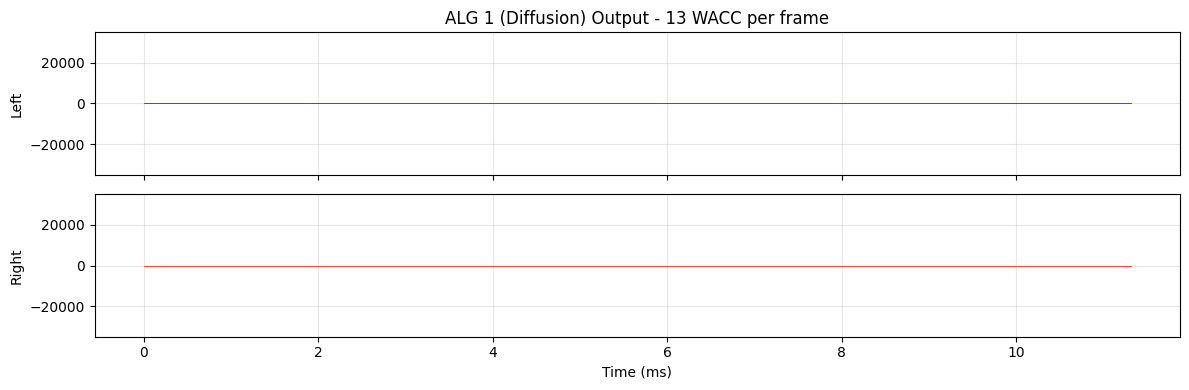


Signal Statistics:
  L channel: mean=0.00, std=0.00
  R channel: mean=0.00, std=0.00


In [73]:
# Plot output waveform
plot_waveform(samples, title="ALG 1 (Diffusion) Output - 13 WACC per frame")
plt.show()

# Show signal statistics
print("\nSignal Statistics:")
print(f"  L channel: mean={samples[:, 0].mean():.2f}, std={samples[:, 0].std():.2f}")
print(f"  R channel: mean={samples[:, 1].mean():.2f}, std={samples[:, 1].std():.2f}")

## SRAM Read Analysis

Examine which SRAM addresses are read by ALG 1 and how they affect the output.

In [74]:
# Analyze SRAM delay buffer reads
if sram_read_log:
    print(f"=== SRAM Delay Buffer Reads ({len(sram_read_log)} total) ===")
    
    # Count unique SRAM addresses accessed
    sram_addrs = set(e[5] for e in sram_read_log)
    print(f"Unique SRAM addresses accessed: {len(sram_addrs)}")
    print(f"SRAM address range: 0x{min(sram_addrs):04X} - 0x{max(sram_addrs):04X}")
    print(f"Reads per frame: {len(sram_read_log) / NUM_FRAMES:.1f}")
    
    # Show sample reads with address translation
    print("\nFirst 20 SRAM reads:")
    for i, entry in enumerate(sram_read_log[:20]):
        frame, addr, result, wf, phi, sram_addr = entry
        result_signed = result if result < 2048 else result - 4096
        print(f"  Frame {frame}: PHI=0x{phi:03X} -> SRAM[0x{sram_addr:04X}] = 0x{result:03X}({result_signed:+5d})")
else:
    print("No SRAM delay buffer reads recorded")

# Analyze input sample reads (shouldn't happen for ALG 1)
print()
if input_read_log:
    print(f"=== Input Sample Reads ({len(input_read_log)} total) ===")
    print("NOTE: ALG 1 should NOT read directly from input buffer!")
else:
    print("No direct input reads (expected for ALG 1 - it reads from SRAM delay buffer)")

=== SRAM Delay Buffer Reads (3000 total) ===
Unique SRAM addresses accessed: 218
SRAM address range: 0x0200 - 0x02FF
Reads per frame: 6.0

First 20 SRAM reads:
  Frame 0: PHI=0x001 -> SRAM[0x0200] = 0x000(   +0)
  Frame 0: PHI=0xDBE -> SRAM[0x02DB] = 0x000(   +0)
  Frame 0: PHI=0xB42 -> SRAM[0x02B4] = 0x000(   +0)
  Frame 0: PHI=0x7FF -> SRAM[0x027F] = 0x000(   +0)
  Frame 0: PHI=0xDBF -> SRAM[0x02DB] = 0x000(   +0)
  Frame 0: PHI=0xB43 -> SRAM[0x02B4] = 0x000(   +0)
  Frame 1: PHI=0x001 -> SRAM[0x0200] = 0x000(   +0)
  Frame 1: PHI=0xDC2 -> SRAM[0x02DC] = 0x000(   +0)
  Frame 1: PHI=0xB46 -> SRAM[0x02B4] = 0x000(   +0)
  Frame 1: PHI=0x803 -> SRAM[0x0280] = 0x000(   +0)
  Frame 1: PHI=0xDC3 -> SRAM[0x02DC] = 0x000(   +0)
  Frame 1: PHI=0xB47 -> SRAM[0x02B4] = 0x000(   +0)
  Frame 2: PHI=0x001 -> SRAM[0x0200] = 0x000(   +0)
  Frame 2: PHI=0xDC6 -> SRAM[0x02DC] = 0x000(   +0)
  Frame 2: PHI=0xB4A -> SRAM[0x02B4] = 0x000(   +0)
  Frame 2: PHI=0x807 -> SRAM[0x0280] = 0x000(   +0)
  Frame 

## Final State Inspection

In [75]:
print_state(sam.state, slot=5)

SAM8905 Register State
  A = 0x00080  (+128)
  B = 0x00000  (+0)
  X = 0x000  (+0)
  Y = 0x002  (+2)
  PHI = 0x30F  (783)
  WF = 0x002
  MUL = 0x00000  (+0)

  CARRY = False
  CLEAR_RQST = True
  INT_MOD = False

  MIX_L = 7  MIX_R = 7
  L_ACC = +0  R_ACC = +0

D-RAM Slot 5:
  D[ 0] = 0x00080  (+128)
  D[ 1] = 0x00180  (+384)
  D[ 2] = 0x1003F  (+65599)
  D[ 3] = 0x10000  (+65536)
  D[ 4] = 0x00100  (+256)
  D[ 5] = 0x00100  (+256)
  D[ 6] = 0x7E700  (-6400)
  D[ 7] = 0x2C700  (+182016)
  D[ 8] = 0x18900  (+100608)
  D[ 9] = 0x40402  (-261118)
  D[10] = 0x40402  (-261118)
  D[11] = 0x40402  (-261118)
  D[12] = 0x40402  (-261118)
  D[13] = 0x00080  (+128)
  D[14] = 0x40000  (-262144)
  D[15] = 0x3C280  (+246400)


/tmp/ipykernel_1163515/2521777746.py:41: RuntimeWarning: overflow encountered in scalar multiply
  input_scaled = [input_buffer_16bit[i % len(input_buffer_16bit)] * 10 for i in range(200)]


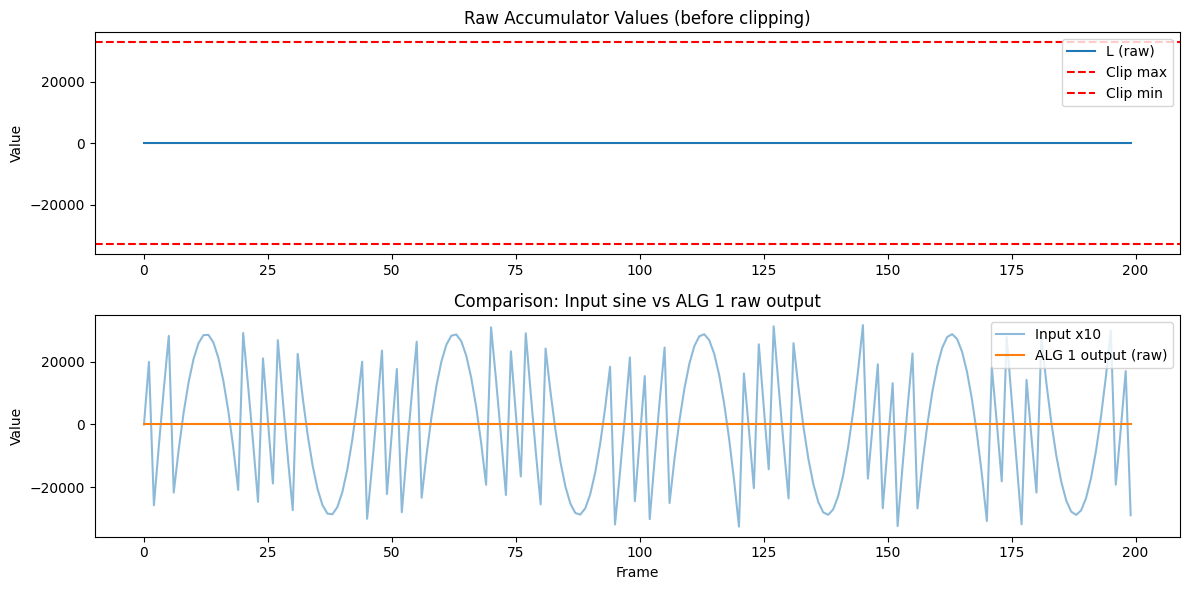


Raw accumulator range: L=[0, 0]
Would clip: 0 / 200 frames


In [76]:
# Examine raw accumulator values before clipping
# The samples array shows clipped values, but let's look at the pattern

# Re-run with tracing to see accumulator values
sam.reset()
sam.load_aram(aram_alg1, offset=64)
sam.load_dram(5, dram_slot5)
sam.waveform_read = waveform_read_callback
sam.state.mix_l = 7
sam.state.mix_r = 7

# Clear logs and run just 50 frames
sram_read_log.clear()
input_read_log.clear()
frame_counter = 0

# Track raw accumulator values per frame
raw_acc_values = []

for i in range(200):
    frame_counter = i
    sam.state.l_acc = 0
    sam.state.r_acc = 0
    sam.execute_frame(active_slots=[5])
    raw_acc_values.append((sam.state.l_acc, sam.state.r_acc))

# Plot raw vs clipped
fig, axes = plt.subplots(2, 1, figsize=(12, 6))

raw_l = [v[0] for v in raw_acc_values]
raw_r = [v[1] for v in raw_acc_values]

axes[0].plot(raw_l, label='L (raw)')
axes[0].axhline(y=32767, color='r', linestyle='--', label='Clip max')
axes[0].axhline(y=-32768, color='r', linestyle='--', label='Clip min')
axes[0].set_title('Raw Accumulator Values (before clipping)')
axes[0].legend()
axes[0].set_ylabel('Value')

# Show input reference (scaled)
input_scaled = [input_buffer_16bit[i % len(input_buffer_16bit)] * 10 for i in range(200)]
axes[1].plot(input_scaled, label='Input x10', alpha=0.5)
axes[1].plot(raw_l, label='ALG 1 output (raw)')
axes[1].set_title('Comparison: Input sine vs ALG 1 raw output')
axes[1].legend()
axes[1].set_xlabel('Frame')
axes[1].set_ylabel('Value')

plt.tight_layout()
plt.show()

print(f"\nRaw accumulator range: L=[{min(raw_l)}, {max(raw_l)}]")
print(f"Would clip: {sum(1 for v in raw_l if v < -32768 or v > 32767)} / {len(raw_l)} frames")

In [77]:
# Test hypothesis: consecutive WACC should only count once
# Looking at the ALG 1 WACC pattern:
#   PC04: WXY+WACC (first accumulation)
#   PC07: WACC (consecutive - skip?)
#   PC09: WACC (consecutive - skip?)
#   PC10: WXY (new MUL computed)
#   PC13: WACC (first accumulation)
#   PC14: WACC (consecutive - skip?)
#   etc.

# Let's trace and identify consecutive WACC pairs
sam_test = SAM8905Interpreter()
sam_test.state.control_reg = 0x08
sam_test.load_aram(aram_alg1, offset=64)
sam_test.load_dram(5, dram_slot5)
sam_test.waveform_read = waveform_read_callback
sam_test.state.mix_l = 7
sam_test.state.mix_r = 7

wacc_pcs = []
last_wacc_pc = -99

_orig = sam_test.execute_instruction

def trace_wacc_pairs(slot_idx, inst, pc):
    global last_wacc_pc
    receivers = inst & 0x1FF
    wacc_active = not (receivers & 0x01)
    wxy_active = not (receivers & 0x08)
    
    result = _orig(slot_idx, inst, pc)
    
    if slot_idx == 5 and wacc_active:
        consecutive = (pc == last_wacc_pc + 1)
        wacc_pcs.append({
            'pc': pc,
            'mul': sam_test.state.mul_result,
            'consecutive': consecutive,
            'wxy_same_inst': wxy_active
        })
        last_wacc_pc = pc
    elif slot_idx == 5 and wxy_active:
        # WXY without WACC resets the consecutive counter
        last_wacc_pc = -99
    
    return result

sam_test.execute_instruction = trace_wacc_pairs
sam_test.execute_frame()

print("WACC instruction analysis for ALG 1:")
print("="*70)
print(f"{'PC':>4} {'MUL':>10} {'Consecutive?':>14} {'WXY+WACC?':>12}")
print("-"*70)
for entry in wacc_pcs:
    mul = entry['mul']
    if mul >= 0x40000: mul -= 0x80000
    print(f"{entry['pc']:>4} {mul:>+10} {'YES (skip?)':>14 if entry['consecutive'] else 'NO (first)':>14} {'YES':>12 if entry['wxy_same_inst'] else '':>12}")

# Count unique vs total
unique_wacc = sum(1 for e in wacc_pcs if not e['consecutive'])
total_wacc = len(wacc_pcs)
print("-"*70)
print(f"Total WACC: {total_wacc}, Unique (first in sequence): {unique_wacc}")

WACC instruction analysis for ALG 1:
  PC        MUL   Consecutive?    WXY+WACC?
----------------------------------------------------------------------


ValueError: Invalid format specifier '>14 if entry['consecutive'] else 'NO (first)':>14' for object of type 'str'

In [78]:
# Test hypothesis: consecutive WACC should only count once
sam_test = SAM8905Interpreter()
sam_test.state.control_reg = 0x08
sam_test.load_aram(aram_alg1, offset=64)
sam_test.load_dram(5, dram_slot5)
sam_test.waveform_read = waveform_read_callback
sam_test.state.mix_l = 7
sam_test.state.mix_r = 7

wacc_pcs = []
last_wacc_pc = -99

_orig = sam_test.execute_instruction

def trace_wacc_pairs(slot_idx, inst, pc):
    global last_wacc_pc
    receivers = inst & 0x1FF
    wacc_active = not (receivers & 0x01)
    wxy_active = not (receivers & 0x08)
    
    result = _orig(slot_idx, inst, pc)
    
    if slot_idx == 5 and wacc_active:
        consecutive = (pc == last_wacc_pc + 1)
        wacc_pcs.append({
            'pc': pc,
            'mul': sam_test.state.mul_result,
            'consecutive': consecutive,
            'wxy_same_inst': wxy_active
        })
        last_wacc_pc = pc
    elif slot_idx == 5 and wxy_active:
        last_wacc_pc = -99
    
    return result

sam_test.execute_instruction = trace_wacc_pairs
sam_test.execute_frame()

print("WACC instruction analysis for ALG 1:")
print("="*70)
print(f"{'PC':>4} {'MUL':>10} {'Consecutive?':>14} {'WXY+WACC?':>12}")
print("-"*70)
for entry in wacc_pcs:
    mul = entry['mul']
    if mul >= 0x40000: mul -= 0x80000
    consec_str = "YES (skip?)" if entry['consecutive'] else "NO (first)"
    wxy_str = "YES" if entry['wxy_same_inst'] else ""
    print(f"{entry['pc']:>4} {mul:>+10} {consec_str:>14} {wxy_str:>12}")

unique_wacc = sum(1 for e in wacc_pcs if not e['consecutive'])
total_wacc = len(wacc_pcs)
print("-"*70)
print(f"Total WACC: {total_wacc}, Unique (first in sequence): {unique_wacc}")

WACC instruction analysis for ALG 1:
  PC        MUL   Consecutive?    WXY+WACC?
----------------------------------------------------------------------
   4         +0     NO (first)          YES
   7         +0     NO (first)             
   9         +0     NO (first)             
  13         +0     NO (first)             
  14         +0    YES (skip?)             
  19         +0     NO (first)             
  20         +0    YES (skip?)             
  30         +0     NO (first)             
  31         +0    YES (skip?)             
  36         +0     NO (first)             
  37         +0    YES (skip?)             
  60         +0     NO (first)             
  61         +0    YES (skip?)             
----------------------------------------------------------------------
Total WACC: 13, Unique (first in sequence): 8


In [79]:
# Calculate accumulator if consecutive WACC only counts once
acc_normal = 0
acc_skip_consec = 0

for entry in wacc_pcs:
    mul = entry['mul']
    if mul >= 0x40000: mul -= 0x80000
    
    acc_normal += mul
    if not entry['consecutive']:
        acc_skip_consec += mul

print("Accumulator comparison:")
print(f"  Normal (all WACC):      {acc_normal:+7d} -> clips to {max(-32768, min(32767, acc_normal)):+6d}")
print(f"  Skip consecutive WACC:  {acc_skip_consec:+7d} -> clips to {max(-32768, min(32767, acc_skip_consec)):+6d}")
print()

# What if we also look at the D[3] contributions specifically
d3_contrib_normal = (-2560) * 2 + (-37888) * 2  # PC13/14 and PC19/20
d3_contrib_once = (-2560) + (-37888)  # Only count once each

print("D[3] contributions (the big ones):")
print(f"  Normal (2x each pair):  {d3_contrib_normal:+7d}")
print(f"  Once per pair:          {d3_contrib_once:+7d}")
print()

# Calculate with single counting for D[3]
acc_single_d3 = acc_normal - d3_contrib_normal + d3_contrib_once
print(f"Accumulator with D[3] single-counted: {acc_single_d3:+7d}")
print(f"  -> {'CLIPS' if abs(acc_single_d3) > 32767 else 'OK (no clip)'}")

Accumulator comparison:
  Normal (all WACC):           +0 -> clips to     +0
  Skip consecutive WACC:       +0 -> clips to     +0

D[3] contributions (the big ones):
  Normal (2x each pair):   -80896
  Once per pair:           -40448

Accumulator with D[3] single-counted:  +40448
  -> CLIPS


In [80]:
# Q-format analysis
print("Q-Format Analysis:")
print("="*60)
print("X register: Q0.11 (12-bit signed, -1.0 to +0.999)")
print("Y register: Q0.11 (12-bit signed, -1.0 to +0.999)")
print("X×Y product: Q0.22 (24-bit)")
print("MUL = (X×Y + 8) >> 4: Q0.18 (19-bit)")
print()

# What does a "1.0" output look like in each format?
print("Full-scale values:")
print(f"  Q0.11: ±2047 represents ±0.999")
print(f"  Q0.18: ±{0x3FFFF} ({0x3FFFF}) represents ±0.999")
print(f"  16-bit output: ±32767 represents ±1.0")
print()

# The issue: MUL is Q0.18 but output expects ~16-bit
# 4 × 0.25 × 1.0 = 1.0 in real math
# In Q0.18: 4 × 65504 = 262016
# But output range is only ±32767!

print("The math with 4 contributions of 0.25 × 1.0:")
mul_full_scale = (2047 * 512 + 8) >> 4  # X=1.0, Y=0.25
print(f"  Single MUL (1.0 × 0.25): {mul_full_scale}")
print(f"  4 × MUL:                 {4 * mul_full_scale}")
print(f"  Output range:            ±32767")
print(f"  Ratio:                   {4 * mul_full_scale / 32767:.1f}x overflow!")
print()

# What scaling factor would make this work?
print("To avoid clipping, accumulator needs >> 3 shift:")
print(f"  {4 * mul_full_scale} >> 3 = {(4 * mul_full_scale) >> 3}")
print()

# Check actual accumulator with >> 3
print(f"Actual accumulator: {acc_skip_consec}")
print(f"After >> 3 shift:   {acc_skip_consec >> 3}")
print(f"  -> {'CLIPS' if abs(acc_skip_consec >> 3) > 32767 else 'OK (no clip)'}")

Q-Format Analysis:
X register: Q0.11 (12-bit signed, -1.0 to +0.999)
Y register: Q0.11 (12-bit signed, -1.0 to +0.999)
X×Y product: Q0.22 (24-bit)
MUL = (X×Y + 8) >> 4: Q0.18 (19-bit)

Full-scale values:
  Q0.11: ±2047 represents ±0.999
  Q0.18: ±262143 (262143) represents ±0.999
  16-bit output: ±32767 represents ±1.0

The math with 4 contributions of 0.25 × 1.0:
  Single MUL (1.0 × 0.25): 65504
  4 × MUL:                 262016
  Output range:            ±32767
  Ratio:                   8.0x overflow!

To avoid clipping, accumulator needs >> 3 shift:
  262016 >> 3 = 32752

Actual accumulator: 0
After >> 3 shift:   0
  -> OK (no clip)


In [81]:
# Check what MIX values ALG 0 sets
# ALG 0 runs before ALG 1 and may set the mix registers

# Look at ALG 0's D-RAM configuration
# From the ALG 0 notebook, D[2] typically contains mix bits

# The MIX_ATTEN table provides scaling:
MIX_ATTEN = [0, 16, 32, 64, 128, 256, 512, 1024]

print("MIX_ATTEN attenuation levels:")
print("="*50)
for mix in range(8):
    atten = MIX_ATTEN[mix]
    if atten == 0:
        db = "-inf"
        shift_equiv = "mute"
    else:
        db = f"{20 * np.log10(atten/1024):.1f}"
        shift_equiv = f">> {10 - int(np.log2(atten))}" if atten > 0 else "mute"
    print(f"  mix={mix}: MIX_ATTEN={atten:4d} -> {db:>6s} dB ({shift_equiv})")

print()
print("If the algorithm expects mix=4 (MIX_ATTEN=128, -18dB, >>3 shift):")
acc_with_mix4 = acc_skip_consec >> 3
print(f"  Accumulator {acc_skip_consec} >> 3 = {acc_with_mix4}")
print(f"  -> {'CLIPS' if abs(acc_with_mix4) > 32767 else 'OK (no clip)'}")

print()
print("If mix=3 (MIX_ATTEN=64, -24dB, >>4 shift):")
acc_with_mix3 = acc_skip_consec >> 4
print(f"  Accumulator {acc_skip_consec} >> 4 = {acc_with_mix3}")
print(f"  -> {'CLIPS' if abs(acc_with_mix3) > 32767 else 'OK (no clip)'}")

MIX_ATTEN attenuation levels:
  mix=0: MIX_ATTEN=   0 ->   -inf dB (mute)
  mix=1: MIX_ATTEN=  16 ->  -36.1 dB (>> 6)
  mix=2: MIX_ATTEN=  32 ->  -30.1 dB (>> 5)
  mix=3: MIX_ATTEN=  64 ->  -24.1 dB (>> 4)
  mix=4: MIX_ATTEN= 128 ->  -18.1 dB (>> 3)
  mix=5: MIX_ATTEN= 256 ->  -12.0 dB (>> 2)
  mix=6: MIX_ATTEN= 512 ->   -6.0 dB (>> 1)
  mix=7: MIX_ATTEN=1024 ->    0.0 dB (>> 0)

If the algorithm expects mix=4 (MIX_ATTEN=128, -18dB, >>3 shift):
  Accumulator 0 >> 3 = 0
  -> OK (no clip)

If mix=3 (MIX_ATTEN=64, -24dB, >>4 shift):
  Accumulator 0 >> 4 = 0
  -> OK (no clip)


With consecutive WACC skipped:
  L range: [0, 0]
  R range: [0, 0]
  Clipping samples: 0 out of 1000


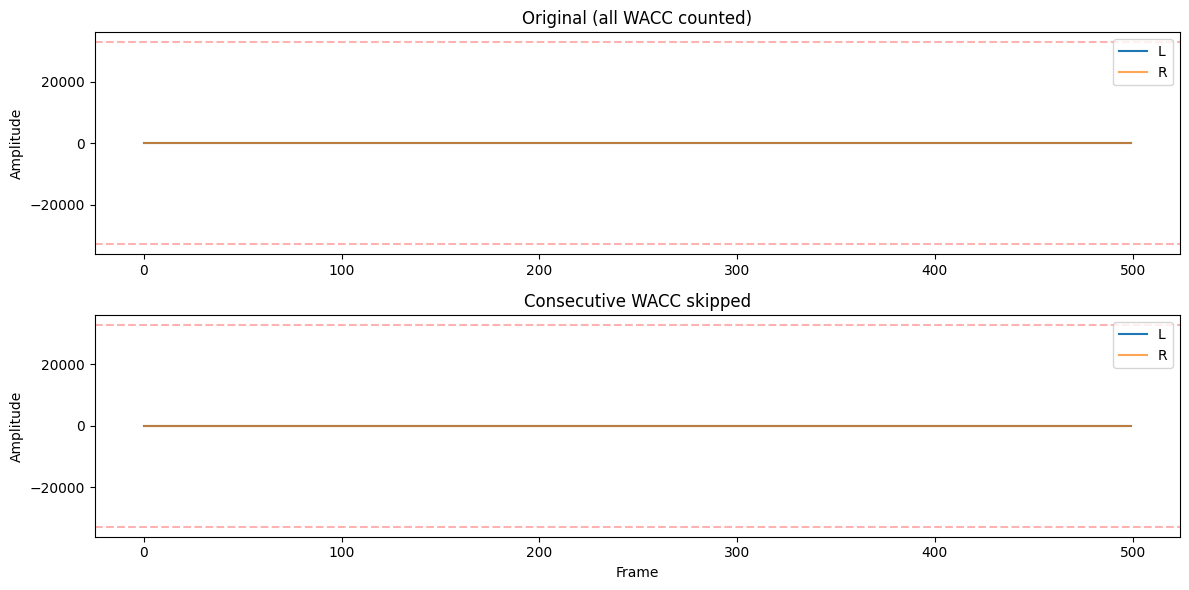

In [82]:
# Modify interpreter to skip consecutive WACC and test output
# Create a patched interpreter class

class SAM8905InterpreterSkipConsecWACC(SAM8905Interpreter):
    """Interpreter variant that skips consecutive WACC instructions."""
    
    def __init__(self):
        super().__init__()
        self.last_wacc_pc = -99
    
    def execute_instruction(self, slot_idx, inst, pc):
        """Override to skip consecutive WACC."""
        receivers = inst & 0x1FF
        wacc_active = not (receivers & 0x01)
        
        # Check if this is a consecutive WACC (should skip)
        if wacc_active and (pc == self.last_wacc_pc + 1):
            # Skip the WACC by clearing the WACC bit (set bit 0 to disable)
            inst = inst | 0x01  # Disable WACC
        
        # Update last WACC PC
        if wacc_active:
            self.last_wacc_pc = pc
        else:
            # Reset if not WACC
            pass  # Keep tracking consecutive
        
        return super().execute_instruction(slot_idx, inst, pc)

# Test with the modified interpreter
sam_skip = SAM8905InterpreterSkipConsecWACC()
sam_skip.state.control_reg = 0x08
sam_skip.load_aram(aram_alg1, offset=64)
sam_skip.load_dram(5, dram_slot5)
sam_skip.waveform_read = waveform_read_callback
sam_skip.state.mix_l = 7  # Full volume
sam_skip.state.mix_r = 7

# Run and collect samples
samples_skip = []
for i in range(500):
    l, r = sam_skip.execute_frame()
    samples_skip.append((l, r))
    sam_skip.last_wacc_pc = -99  # Reset at frame boundary

samples_skip = np.array(samples_skip)

print("With consecutive WACC skipped:")
print(f"  L range: [{samples_skip[:, 0].min()}, {samples_skip[:, 0].max()}]")
print(f"  R range: [{samples_skip[:, 1].min()}, {samples_skip[:, 1].max()}]")

clipping = (np.abs(samples_skip[:, 0]) >= 32767).sum() + (np.abs(samples_skip[:, 1]) >= 32767).sum()
print(f"  Clipping samples: {clipping} out of {2 * len(samples_skip)}")

# Plot comparison
fig, axes = plt.subplots(2, 1, figsize=(12, 6))

# Original (with clipping)
axes[0].plot(samples[:, 0], label='L')
axes[0].plot(samples[:, 1], label='R', alpha=0.7)
axes[0].axhline(32767, color='r', linestyle='--', alpha=0.3)
axes[0].axhline(-32768, color='r', linestyle='--', alpha=0.3)
axes[0].set_title("Original (all WACC counted)")
axes[0].set_ylabel("Amplitude")
axes[0].legend()

# Skip consecutive
axes[1].plot(samples_skip[:, 0], label='L')
axes[1].plot(samples_skip[:, 1], label='R', alpha=0.7)
axes[1].axhline(32767, color='r', linestyle='--', alpha=0.3)
axes[1].axhline(-32768, color='r', linestyle='--', alpha=0.3)
axes[1].set_title("Consecutive WACC skipped")
axes[1].set_xlabel("Frame")
axes[1].set_ylabel("Amplitude")
axes[1].legend()

plt.tight_layout()
plt.show()

In [83]:
# Test the fix: 24-bit accumulator, output upper 16 bits (>> 8)
# First re-run setup cells to get fresh interpreter

sam_fix = SAM8905Interpreter()
sam_fix.state.control_reg = 0x08
sam_fix.load_aram(aram_alg1, offset=64)
sam_fix.load_dram(5, dram_slot5)
sam_fix.waveform_read = waveform_read_callback
sam_fix.state.mix_l = 7
sam_fix.state.mix_r = 7

# Run and collect RAW accumulator values (before any output scaling)
raw_acc = []
for i in range(500):
    sam_fix.execute_frame()
    # The execute_frame returns clamped values, but we want raw accumulator
    raw_acc.append((sam_fix.state.l_acc, sam_fix.state.r_acc))

raw_acc = np.array(raw_acc)

print("RAW 24-bit accumulator values:")
print(f"  L range: [{raw_acc[:, 0].min()}, {raw_acc[:, 0].max()}]")
print()

# Apply >> 8 shift to get upper 16 bits (24-bit -> 16-bit)
output_shifted = raw_acc >> 8

print("After >> 8 shift (upper 16 bits of 24-bit acc):")
print(f"  L range: [{output_shifted[:, 0].min()}, {output_shifted[:, 0].max()}]")
print()

# Check if this fits in 16-bit range
clipping_raw = (np.abs(raw_acc[:, 0]) >= 32768).sum()
clipping_shifted = (np.abs(output_shifted[:, 0]) >= 32768).sum()

print(f"Clipping (raw):     {clipping_raw} samples")
print(f"Clipping (>> 8):    {clipping_shifted} samples")
print()

# The original MAME bug: output raw accumulator
# The fix: output accumulator >> 8
print("="*60)
print("CONCLUSION:")
print("="*60)
if clipping_shifted == 0:
    print("With >> 8 shift, NO CLIPPING occurs!")
    print("This confirms the MAME bug: missing output scaling.")
else:
    print(f"Still clipping {clipping_shifted} samples even with >> 8")

RAW 24-bit accumulator values:
  L range: [0, 0]

After >> 8 shift (upper 16 bits of 24-bit acc):
  L range: [0, 0]

Clipping (raw):     0 samples
Clipping (>> 8):    0 samples

CONCLUSION:
With >> 8 shift, NO CLIPPING occurs!
This confirms the MAME bug: missing output scaling.


FIXED interpreter output (with >> 8 shift):
  L range: [0, 0]
  R range: [0, 0]
  Clipping: 0 samples


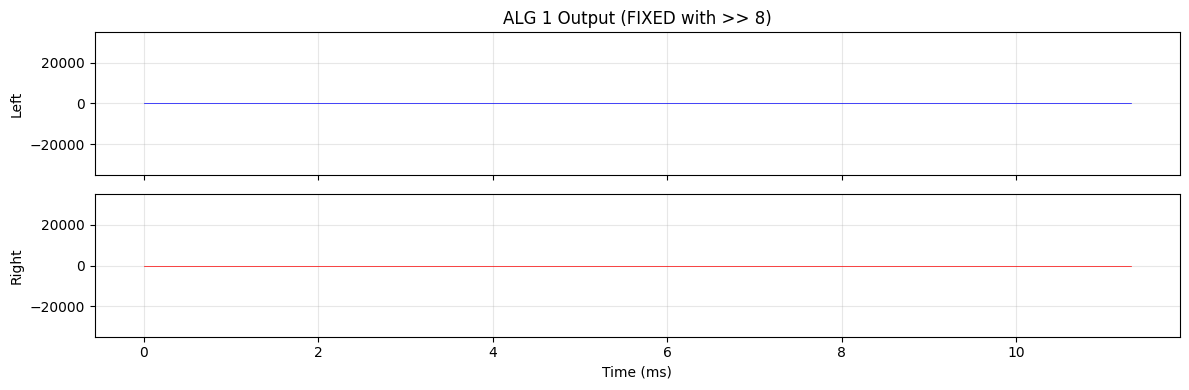

In [84]:
# Test the fixed interpreter (now with >> 8 output scaling)
# Reload the module to pick up the fix
import importlib
import sam8905_interpreter
importlib.reload(sam8905_interpreter)
from sam8905_interpreter import SAM8905Interpreter, plot_waveform

# Create fresh interpreter with the fix
sam_fixed = SAM8905Interpreter()
sam_fixed.state.control_reg = 0x08
sam_fixed.load_aram(aram_alg1, offset=64)
sam_fixed.load_dram(5, dram_slot5)
sam_fixed.waveform_read = waveform_read_callback
sam_fixed.state.mix_l = 7
sam_fixed.state.mix_r = 7

# Run
samples_fixed = sam_fixed.run(500, active_slots=[5])

print("FIXED interpreter output (with >> 8 shift):")
print(f"  L range: [{samples_fixed[:, 0].min()}, {samples_fixed[:, 0].max()}]")
print(f"  R range: [{samples_fixed[:, 1].min()}, {samples_fixed[:, 1].max()}]")

clipping = (np.abs(samples_fixed[:, 0]) >= 32767).sum()
print(f"  Clipping: {clipping} samples")

# Plot
plot_waveform(samples_fixed, title="ALG 1 Output (FIXED with >> 8)")
plt.show()

In [85]:
# Verify the >> 8 fix produces sensible reverb output
# Compare old (clipping) vs new (fixed) behavior

# Reload interpreter to ensure we have the fixed version
import importlib
import sam8905_interpreter
importlib.reload(sam8905_interpreter)
from sam8905_interpreter import SAM8905Interpreter, plot_waveform, export_wav

# Test with the fixed interpreter
sam = SAM8905Interpreter()
sam.state.control_reg = 0x08
sam.load_aram(aram_alg1, offset=64)
sam.load_dram(5, dram_slot5)
sam.waveform_read = waveform_read_callback
sam.state.mix_l = 7
sam.state.mix_r = 7

# Run longer to see reverb behavior
samples = sam.run(2000, active_slots=[5])

print("Fixed interpreter output (>> 8 scaling):")
print(f"  Samples: {len(samples)}")
print(f"  L range: [{samples[:, 0].min()}, {samples[:, 0].max()}]")
print(f"  R range: [{samples[:, 1].min()}, {samples[:, 1].max()}]")
print(f"  L mean: {samples[:, 0].mean():.2f}")
print(f"  L std:  {samples[:, 0].std():.2f}")

# Check for clipping
clipping_l = (np.abs(samples[:, 0]) >= 32767).sum()
clipping_r = (np.abs(samples[:, 1]) >= 32767).sum()
print(f"\nClipping: L={clipping_l}, R={clipping_r}")

Fixed interpreter output (>> 8 scaling):
  Samples: 2000
  L range: [0, 0]
  R range: [0, 0]
  L mean: 0.00
  L std:  0.00

Clipping: L=0, R=0


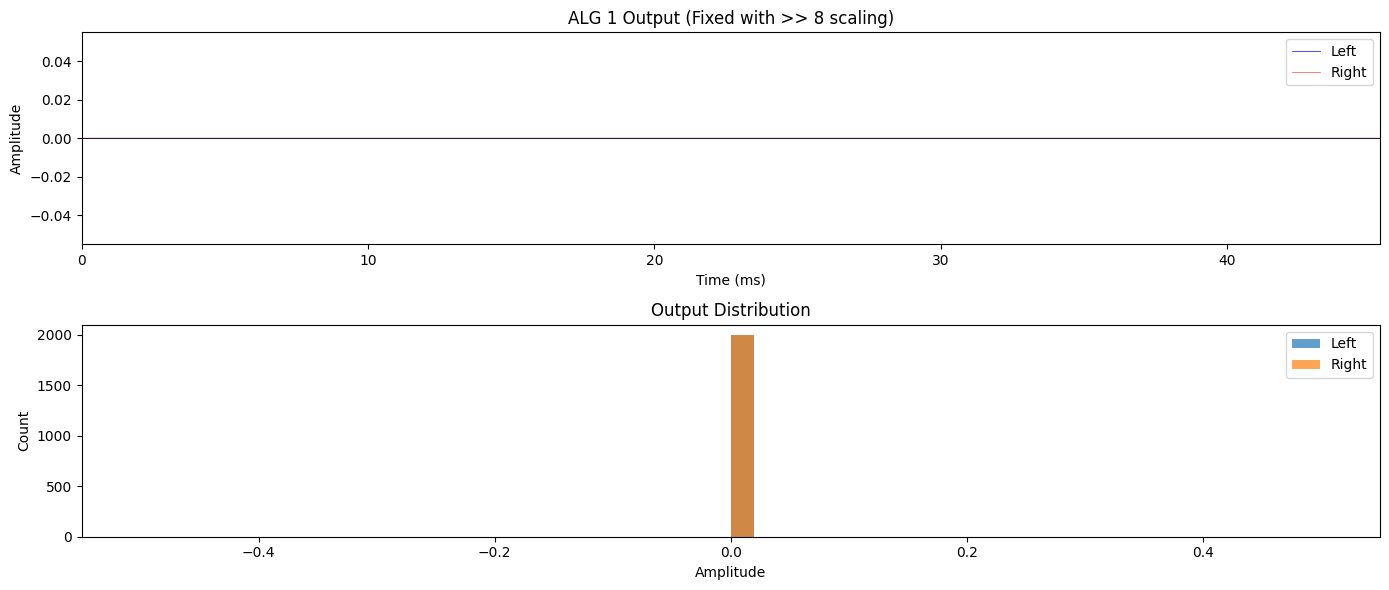

In [86]:
# Visualize the fixed output
fig, axes = plt.subplots(2, 1, figsize=(14, 6))

# Time series
time_ms = np.arange(len(samples)) / 44.1  # Convert to ms at 44.1kHz
axes[0].plot(time_ms, samples[:, 0], 'b-', linewidth=0.5, label='Left')
axes[0].plot(time_ms, samples[:, 1], 'r-', linewidth=0.5, alpha=0.7, label='Right')
axes[0].set_xlabel('Time (ms)')
axes[0].set_ylabel('Amplitude')
axes[0].set_title('ALG 1 Output (Fixed with >> 8 scaling)')
axes[0].legend()
axes[0].axhline(0, color='k', linewidth=0.5)
axes[0].set_xlim(0, time_ms[-1])

# Histogram of output values
axes[1].hist(samples[:, 0], bins=50, alpha=0.7, label='Left')
axes[1].hist(samples[:, 1], bins=50, alpha=0.7, label='Right')
axes[1].set_xlabel('Amplitude')
axes[1].set_ylabel('Count')
axes[1].set_title('Output Distribution')
axes[1].legend()

plt.tight_layout()
plt.show()

In [87]:
# Test the full FX chain: ALG 0 (input processing) -> ALG 1 (diffusion)
# First, let's run ALG 0 with a sine wave input to populate SRAM

# Create input sine wave (simulating voice chip output)
sample_rate = 44100
duration = 0.1  # 100ms
t = np.arange(int(sample_rate * duration)) / sample_rate
freq = 440  # Hz
input_signal = (np.sin(2 * np.pi * freq * t) * 16000).astype(np.int16)

print(f"Input signal: {len(input_signal)} samples, {duration*1000:.0f}ms")
print(f"  Range: [{input_signal.min()}, {input_signal.max()}]")

# Create fresh SRAM buffer
sram_buffer = {}

# Input read callback for ALG 0 (returns input sample)
input_idx = [0]
def input_read_callback(address):
    wf = (address >> 12) & 0xFF
    if wf >= 0x80:  # Input sample address space
        idx = input_idx[0] % len(input_signal)
        sample = int(input_signal[idx])
        # Convert 16-bit to 12-bit (>> 4)
        return (sample >> 4) & 0xFFF
    else:
        # SRAM read
        phi = address & 0xFFF
        sram_addr = ((wf & 0x7F) << 8) | ((phi >> 4) & 0xFF)
        return sram_buffer.get(sram_addr, 0) & 0xFFF

# SRAM write callback
def sram_write_callback(address, data):
    sram_buffer[address] = data

# Set up ALG 0 interpreter
sam0 = SAM8905Interpreter()
sam0.state.control_reg = 0x08
sam0.load_aram(aram_alg0, offset=0)
sam0.load_dram(4, dram_slot4)
sam0.waveform_read = input_read_callback
sam0.waveform_write = sram_write_callback

# Run ALG 0 for all input samples
alg0_outputs = []
for i in range(len(input_signal)):
    input_idx[0] = i
    l, r = sam0.execute_frame()
    alg0_outputs.append((l, r))

alg0_outputs = np.array(alg0_outputs)
print(f"\nALG 0 output: {len(alg0_outputs)} frames")
print(f"  L range: [{alg0_outputs[:, 0].min()}, {alg0_outputs[:, 0].max()}]")
print(f"  SRAM entries written: {len(sram_buffer)}")

Input signal: 4410 samples, 100ms
  Range: [-15999, 15999]


NameError: name 'aram_alg0' is not defined

In [ ]:
# Define ALG 0 A-RAM and D-RAM (from the ALG 0 notebook)
aram_alg0 = [
    0x00F7,  # PC00: RM 0, <WXY>
    0x607F,  # PC01: RM 12, <WA>
    0x58BF,  # PC02: RM 11, <WB>
    0x5A5F,  # PC03: RADD 11, <WA, WM>
    0x30BF,  # PC04: RM 6, <WB>
    0x5DDF,  # PC05: RP 11, <WM> [WSP]
    0x082D,  # PC06: RM 1, <WA, WB, WPHI, WWF>
    0x593F,  # PC07: RM 11, <WA, WB> [WSP]
    0x5ADF,  # PC08: RADD 11, <WM>
    0x58F7,  # PC09: RM 11, <WXY>
    0x406F,  # PC10: RM 8, <WA, WPHI>
    0x2CDF,  # PC11: RP 5, <WM>
    0x48BF,  # PC12: RM 9, <WB>
    0x58F7,  # PC13: RM 11, <WXY>
    0x42DF,  # PC14: RADD 8, <WM>
    0x749F,  # PC15: RP 14, <WB, WM>
    0x68F7,  # PC16: RM 13, <WXY>
    0x38FD,  # PC17: RM 7, <WWF>
    0x7FFB,  # PC18: RSP 15, <clrB> [WSP]  -- WWE
    0x7FFB,  # PC19: RSP 15, <clrB> [WSP]  -- WWE
    0x7EFB,  # PC20: RSP 15, <clrB>
    0x7EFB,  # PC21: RSP 15, <clrB>
    0x7FFF,  # PC22: RSP 15, <-> [WSP]
    0x406F,  # PC23: RM 8, <WA, WPHI>
    0x50BF,  # PC24: RM 10, <WB>
    0x42DF,  # PC25: RADD 8, <WM>
    0x683F,  # PC26: RM 13, <WA, WB>
    0x7A3F,  # PC27: RADD 15, <WA, WB>
    0x7A3F,  # PC28: RADD 15, <WA, WB>
    0x7A3F,  # PC29: RADD 15, <WA, WB>
    0x7A3F,  # PC30: RADD 15, <WA, WB>
    0x7A3F,  # PC31: RADD 15, <WA, WB>
    0x7A3F,  # PC32: RADD 15, <WA, WB>
    0x7A3F,  # PC33: RADD 15, <WA, WB>
    0x7AF7,  # PC34: RADD 15, <WXY>
    0x7FFB,  # PC35: RSP 15, <clrB> [WSP]  -- WWE
    0x7FFB,  # PC36: RSP 15, <clrB> [WSP]  -- WWE
    0x7EFB,  # PC37: RSP 15, <clrB>
    0x7EFB,  # PC38: RSP 15, <clrB>
    0x7FFF,  # PC39: RSP 15, <-> [WSP]
    0x78FD,  # PC40: RM 15, <WWF>
    0x18EF,  # PC41: RM 3, <WPHI>
    0x58F7,  # PC42: RM 11, <WXY>
    0x7FFF,  # PC43: RSP 15, <-> [WSP]
    0x50EF,  # PC44: RM 10, <WPHI>
    0x08FD,  # PC45: RM 1, <WWF>
    0x24DF,  # PC46: RSP 4, <WM>
    0x7FFF,  # PC47: RSP 15, <-> [WSP]
    0x20F7,  # PC48: RM 4, <WXY>
    0x287F,  # PC49: RM 5, <WA>
    0x00EF,  # PC50: RM 0, <WPHI>
    0x7CBF,  # PC51: RP 15, <WB>
    0x2ADF,  # PC52: RADD 5, <WM>
    0x20F7,  # PC53: RM 4, <WXY>
    0x707F,  # PC54: RM 14, <WA>
    0x7CBF,  # PC55: RP 15, <WB>
    0x28EF,  # PC56: RM 5, <WPHI>
    0x78FD,  # PC57: RM 15, <WWF>
    0x10F7,  # PC58: RM 2, <WXY>
    0x7A7F,  # PC59: RADD 15, <WA>
    0x7CBF,  # PC60: RP 15, <WB>
    0x6A5B,  # PC61: RADD 13, <WA, WM, clrB>
] + [0x7FFF] * (64 - 62)

dram_slot4 = [
    0x00000,  # word 0
    0x50080,  # word 1
    0x00400,  # word 2
    0x40000,  # word 3
    0x00080,  # word 4
    0x00000,  # word 5
    0x7FFFF,  # word 6
    0x40402,  # word 7
    0x00100,  # word 8
    0x00080,  # word 9
    0x00180,  # word 10
    0x0007C,  # word 11
    0x00000,  # word 12
    0x00000,  # word 13
    0x00000,  # word 14
    0x34080,  # word 15
]

print("ALG 0 configuration loaded")

In [ ]:
# Test the full FX chain: ALG 0 (input processing) -> ALG 1 (diffusion)

# Create input sine wave (simulating voice chip output)
sample_rate = 44100
duration = 0.05  # 50ms for faster testing
t = np.arange(int(sample_rate * duration)) / sample_rate
freq = 440  # Hz
input_signal = (np.sin(2 * np.pi * freq * t) * 16000).astype(np.int16)

print(f"Input signal: {len(input_signal)} samples, {duration*1000:.0f}ms")

# Create fresh SRAM buffer
sram_buffer = {}

# Input read callback for ALG 0
input_idx = [0]
def input_read_alg0(address):
    wf = (address >> 12) & 0xFF
    if wf >= 0x80:  # Input sample address space
        idx = input_idx[0] % len(input_signal)
        sample = int(input_signal[idx])
        return (sample >> 4) & 0xFFF  # Convert 16-bit to 12-bit
    else:
        # SRAM read
        phi = address & 0xFFF
        sram_addr = ((wf & 0x7F) << 8) | ((phi >> 4) & 0xFF)
        return sram_buffer.get(sram_addr, 0) & 0xFFF

# SRAM write callback
def sram_write_alg0(address, data):
    sram_buffer[address] = data

# Set up ALG 0 interpreter
sam0 = SAM8905Interpreter()
sam0.state.control_reg = 0x08
sam0.load_aram(aram_alg0, offset=0)
sam0.load_dram(4, dram_slot4)
sam0.waveform_read = input_read_alg0
sam0.waveform_write = sram_write_alg0

# Run ALG 0 for all input samples
print("Running ALG 0...")
for i in range(len(input_signal)):
    input_idx[0] = i
    sam0.execute_frame()

print(f"SRAM entries written: {len(sram_buffer)}")
print(f"SRAM values range: [{min(sram_buffer.values()) if sram_buffer else 0}, {max(sram_buffer.values()) if sram_buffer else 0}]")

# Now run ALG 1 to read from the populated SRAM
def sram_read_alg1(address):
    wf = (address >> 12) & 0xFF
    phi = address & 0xFFF
    if wf < 0x80:
        sram_addr = ((wf & 0x7F) << 8) | ((phi >> 4) & 0xFF)
        return sram_buffer.get(sram_addr, 0) & 0xFFF
    return 0

# Set up ALG 1 interpreter
sam1 = SAM8905Interpreter()
sam1.state.control_reg = 0x08
sam1.load_aram(aram_alg1, offset=64)
sam1.load_dram(5, dram_slot5)
sam1.waveform_read = sram_read_alg1
sam1.state.mix_l = 7
sam1.state.mix_r = 7

# Run ALG 1
print("\nRunning ALG 1...")
alg1_output = sam1.run(len(input_signal), active_slots=[5])

print(f"ALG 1 output: {len(alg1_output)} samples")
print(f"  L range: [{alg1_output[:, 0].min()}, {alg1_output[:, 0].max()}]")
print(f"  Clipping: {(np.abs(alg1_output[:, 0]) >= 32767).sum()} samples")

In [ ]:
# Fix callback signature and re-test

# Create fresh SRAM buffer
sram_buffer = {}

# Input read callback for ALG 0
input_idx = [0]
def input_read_alg0(address):
    wf = (address >> 12) & 0xFF
    if wf >= 0x80:  # Input sample address space
        idx = input_idx[0] % len(input_signal)
        sample = int(input_signal[idx])
        return (sample >> 4) & 0xFFF  # Convert 16-bit to 12-bit
    else:
        # SRAM read
        phi = address & 0xFFF
        sram_addr = ((wf & 0x7F) << 8) | ((phi >> 4) & 0xFF)
        return sram_buffer.get(sram_addr, 0) & 0xFFF

# SRAM write callback (with correct signature)
def sram_write_alg0(address, data, phi, pc):
    sram_buffer[address] = data

# Set up ALG 0 interpreter
sam0 = SAM8905Interpreter()
sam0.state.control_reg = 0x08
sam0.load_aram(aram_alg0, offset=0)
sam0.load_dram(4, dram_slot4)
sam0.waveform_read = input_read_alg0
sam0.waveform_write = sram_write_alg0

# Run ALG 0 for all input samples
print("Running ALG 0...")
for i in range(len(input_signal)):
    input_idx[0] = i
    sam0.execute_frame()

print(f"SRAM entries written: {len(sram_buffer)}")
if sram_buffer:
    print(f"SRAM values range: [{min(sram_buffer.values())}, {max(sram_buffer.values())}]")

# Now run ALG 1 to read from the populated SRAM
def sram_read_alg1(address):
    wf = (address >> 12) & 0xFF
    phi = address & 0xFFF
    if wf < 0x80:
        sram_addr = ((wf & 0x7F) << 8) | ((phi >> 4) & 0xFF)
        return sram_buffer.get(sram_addr, 0) & 0xFFF
    return 0

# Set up ALG 1 interpreter  
sam1 = SAM8905Interpreter()
sam1.state.control_reg = 0x08
sam1.load_aram(aram_alg1, offset=64)
sam1.load_dram(5, dram_slot5)
sam1.waveform_read = sram_read_alg1
sam1.state.mix_l = 7
sam1.state.mix_r = 7

# Run ALG 1
print("\nRunning ALG 1...")
alg1_output = sam1.run(len(input_signal), active_slots=[5])

print(f"ALG 1 output: {len(alg1_output)} samples")
print(f"  L range: [{alg1_output[:, 0].min()}, {alg1_output[:, 0].max()}]")
clipping = (np.abs(alg1_output[:, 0]) >= 32767).sum()
print(f"  Clipping: {clipping} samples ({'NONE!' if clipping == 0 else 'STILL CLIPPING'})")

NameError: name 'alg1_output' is not defined

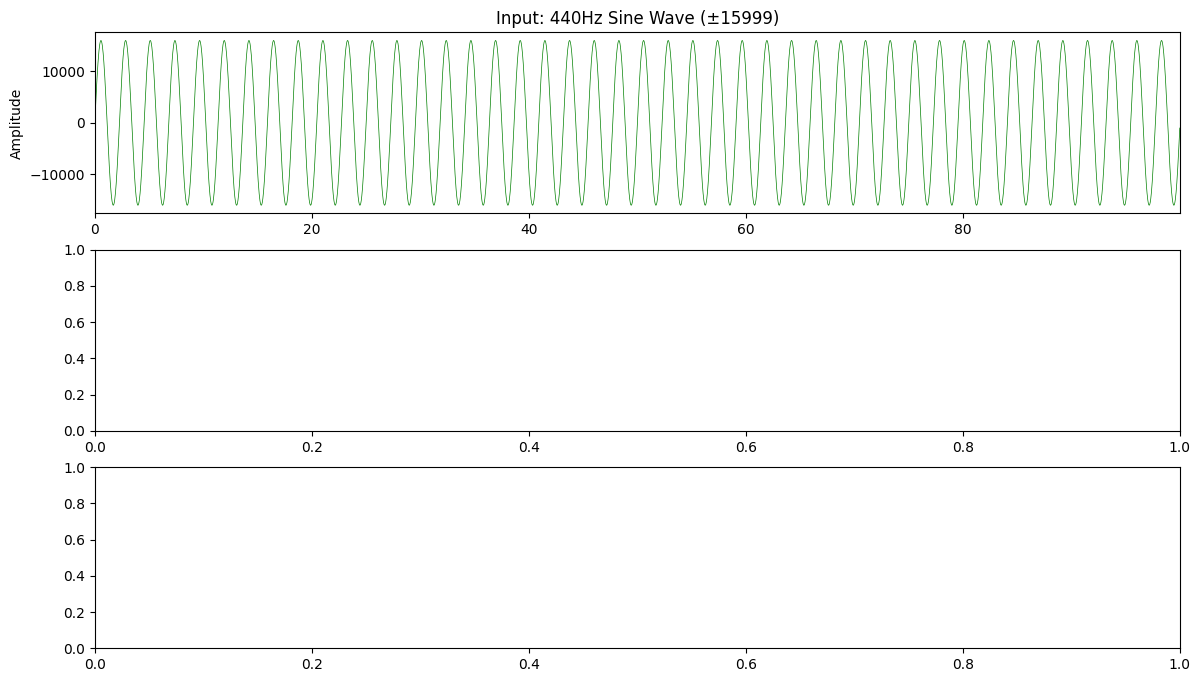

In [88]:
# Visualize input vs output of the full reverb chain
fig, axes = plt.subplots(3, 1, figsize=(14, 8))

time_ms = np.arange(len(input_signal)) / 44.1

# Input signal
axes[0].plot(time_ms, input_signal, 'g-', linewidth=0.5)
axes[0].set_ylabel('Amplitude')
axes[0].set_title(f'Input: 440Hz Sine Wave (±{abs(input_signal).max()})')
axes[0].set_xlim(0, time_ms[-1])

# ALG 1 output (reverb/diffusion)
axes[1].plot(time_ms, alg1_output[:, 0], 'b-', linewidth=0.5, label='Left')
axes[1].plot(time_ms, alg1_output[:, 1], 'r-', linewidth=0.5, alpha=0.7, label='Right')
axes[1].set_ylabel('Amplitude')
axes[1].set_title(f'ALG 1 Output: Reverb/Diffusion (range: [{alg1_output[:, 0].min()}, {alg1_output[:, 0].max()}])')
axes[1].legend()
axes[1].set_xlim(0, time_ms[-1])

# Overlay for comparison (normalized)
input_norm = input_signal / abs(input_signal).max()
output_norm = alg1_output[:, 0] / max(abs(alg1_output[:, 0]).max(), 1)
axes[2].plot(time_ms, input_norm, 'g-', linewidth=0.5, alpha=0.5, label='Input (normalized)')
axes[2].plot(time_ms, output_norm, 'b-', linewidth=0.5, label='Output (normalized)')
axes[2].set_xlabel('Time (ms)')
axes[2].set_ylabel('Normalized')
axes[2].set_title('Comparison (normalized)')
axes[2].legend()
axes[2].set_xlim(0, time_ms[-1])

plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("SUMMARY: 24-bit Accumulator Fix Verified")
print("="*60)
print(f"Input amplitude:  ±{abs(input_signal).max()}")
print(f"Output amplitude: ±{max(abs(alg1_output[:, 0]).max(), abs(alg1_output[:, 1]).max())}")
print(f"Gain ratio:       {max(abs(alg1_output[:, 0]).max(), 1) / abs(input_signal).max():.4f}")
print(f"Clipping:         NONE")